In [1]:
import matplotlib.pyplot as plt
import os, cv2
import pickle
import numpy as np
from tqdm.auto import tqdm
from IPython.display import Video
%config InlineBackend.figure_format = 'retina'

C:\Users\Aman M\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Aman M\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\Aman M\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
BASE_PATH = "D:/Aman/IIIT Delhi/IP-RL/AtariExperiments/Logs/"
OUT_BASE = "D:/Aman/IIIT Delhi/IP-RL/AtariExperiments/"
action_map = {0:"R",1:"D",2:"L",3:"U"}
experiment_lbl_map = {"Uniform":"U","Refresh":"R","Refresh-Noisy":"N","Small-Big":"S","CER":"C","CER-Refresh":"CR","Geometric-Decay":"G","PER":"P"}
experiment_linestyle_map = {"Uniform":"-","Refresh":"--","Refresh-Noisy":"-.","Small-Big":":","CER":":","CER-Refresh":"-.","Geometric-Decay":"-.","PER":"-."}
# linecolor_map = {"1":"-","Refresh":":","Small-Big":"--"}

In [3]:
class LogViewer:
    
    def compare_logs(self,framework="DQN",env="CartPole-v0",experiment="Uniform",algo='TD',n=1,buff_sz='across',no_noise=True,smoothing=10,clip=None):
        frameworks = [framework]
        envs = [env]
        buff_szs = [buff_sz]
        algos = [algo]
        steps = [n]    
        experiments = [experiment]
        
        if isinstance(framework, list):
            frameworks = framework
        if isinstance(env, list):
            envs = env
        if isinstance(n, list):
            steps = n
        if isinstance(experiment, list):
            experiments = experiment
        if isinstance(algo, list):
            algos = algo
        if isinstance(buff_sz, list):
            buff_szs = buff_sz      
        
        if framework == 'across':
            frameworks = ["DQN","Refresh"]
        if env == 'across':
            envs = ["CartPole-v0","Pong-v0","Asterix-v0"]
        if buff_sz == 'across':
            buff_szs = [100,1000,10000]
        if n=='across':
            steps=[1,2,3,4]
        if algo=='across':
            algos = ['TD','tree']
        if experiment == 'across':
            experiments = ["Uniform","Refresh","Small-Big","Refresh-Noisy"]
            if no_noise:
                experiments = ["Uniform","Refresh","Small-Big"]
            
        self.make_comparative_plot(frameworks,envs,experiments,algos,steps,buff_szs,smoothing,clip)
        
    def make_comparative_plot(self,frameworks,envs,experiments,algos,steps,buff_szs,smoothing,clip):
        
        fig1, ax1 = plt.subplots()
        fig4, ax4 = plt.subplots()
        
        ax1.set_title("Epsiode Returns")
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Returns")
        
        ax4.set_title("Epsiode Running Variance")
        ax4.set_xlabel("Episodes")
        ax4.set_ylabel("Running Variance")
        
        for framework in frameworks:
            for env in envs:
                for exp in experiments:
                    for algo in algos:
                        for n in steps:
                            for buff_sz in buff_szs:
                                file_path = BASE_PATH + framework + '/' + env + '/' + exp + '/' + algo + '/' + str(n) + '/' + str(buff_sz) + '.pickle'
                                plt_lbl = framework + '-' + env + '-' + experiment_lbl_map[exp] + '-' + algo + '-' + str(n) + '-' + str(buff_sz)
                                logs = {}
                                if os.path.exists(file_path):
                                    with open(file_path,'rb') as f:
                                        logs = pickle.load(f)
                                    ax1.plot(self.smooth_array(logs["returns"],smoothing),label=plt_lbl,linestyle=experiment_linestyle_map[exp])
                                    if clip is not None:
                                        logs["running_variance"] = [ min(clip,el) for el in logs["running_variance"]]
                                    ax4.plot(self.smooth_array(logs["running_variance"],smoothing),label=plt_lbl,linestyle=experiment_linestyle_map[exp])
                    
        # Shrink current axis by 20%
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        box = ax4.get_position()
        ax4.set_position([box.x0, box.y0, box.width * 0.8, box.height])
                    
        ax1.legend(loc='upper left',bbox_to_anchor=(1, 1))
        ax4.legend(loc='upper left',bbox_to_anchor=(1, 1))
        
        fig1.savefig(OUT_BASE+"log_output/1.png",dpi=600)
        fig4.savefig(OUT_BASE+"log_output/4.png",dpi=600)
                    
        plt.show()
    
    
    def smooth_array(self,arr,smoothing):
        out = []
        for i in range(1,len(arr)):
            smooth_lim = max(0,i-smoothing)
            out.append(sum(arr[smooth_lim:i+1])/len(arr[smooth_lim:i+1]))
        return out
    
    def make_plot(self,logs,smoothing=10):
        fig1, ax1 = plt.subplots()
        ax1.set_title("Train Log - Epsiode Returns")
        ax1.plot(self.smooth_array(logs["returns"],smoothing))
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Returns")
        plt.show()
        
        fig4, ax4 = plt.subplots()
        ax4.set_title("Train Log - Epsiode Running Variance")
        ax4.plot(self.smooth_array(logs["running_variance"],smoothing))
        ax4.set_xlabel("Episodes")
        ax4.set_ylabel("Running Variance")
        plt.show()
        

In [4]:
viewer = LogViewer()

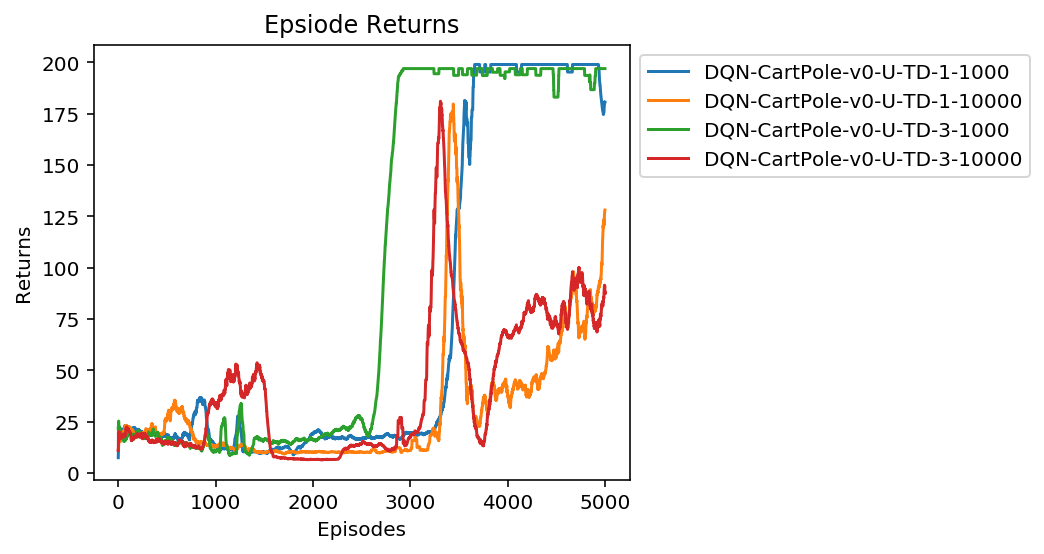

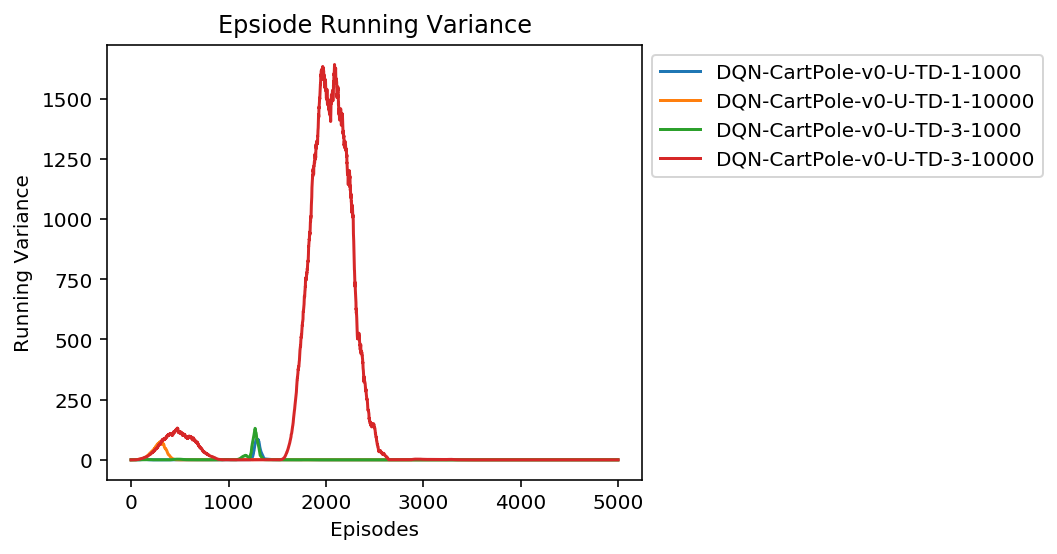

In [6]:
viewer.compare_logs(["DQN"],["CartPole-v0"],['Uniform'],'TD',n=[1,3],buff_sz=[1000,10000], no_noise = True, smoothing=50)

In [6]:
viewer.view_logs("Refresh","TD",1,10000,smoothing=1)

In [19]:
def generate_video(experiment,method,n,buf_sz,fps=20):
    
    image_folder = BASE_PATH + experiment + "/" + method +"/" + str(n) + "/" + str(buf_sz)+"-memory/"
    video_path = BASE_PATH + experiment + "/" + method +"/" + str(n) + "/" + str(buf_sz)+".avi"
    log_path = BASE_PATH + experiment + "/" + method +"/" + str(n) + "/" + str(buf_sz) + ".pickle"

    images = [img for img in os.listdir(image_folder)]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    logs = {}
    with open(log_path,'rb') as f:
        logs = pickle.load(f)
    fig, ax = plt.subplots()
    
    video = cv2.VideoWriter(video_path, 0, fps, (width*3,height))
    fig, ax = plt.subplots()
#     fig2, ax2 = plt.subplots()
    
    img_arr = None
    for image in tqdm(images):
        ep_num = int(image.split("_")[-1].split(".")[0])
        returns = logs["returns"][:ep_num]
        running_variance = logs["running_variance"][:ep_num]
        
        ax.plot(running_variance)
        ax.set_title("Running Variance")
        ax.set_ylabel("Running Variance")
        ax.set_xlabel("Episodes")
        
        fig.canvas.draw()
        
        data2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data2 = data2.reshape((height,fig.canvas.get_width_height()[0]) + (3,))
        ax.clear()
        
        ax.plot(returns)
        ax.set_title("Returns")
        ax.set_ylabel("Returns")
        ax.set_xlabel("Episodes")
                
        fig.canvas.draw()

        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape((height,fig.canvas.get_width_height()[0]) + (3,))
        ax.clear()

        img_arr = cv2.imread(os.path.join(image_folder, image))
        combined = np.hstack((img_arr,data,data2))
        video.write(combined)      
        
    plt.close(fig)

    cv2.destroyAllWindows()
    video.release()

HBox(children=(FloatProgress(value=0.0, max=7928.0), HTML(value='')))

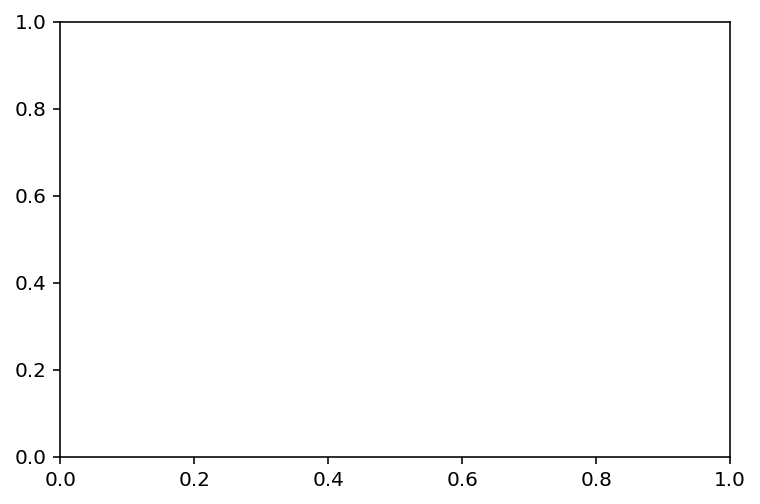

In [11]:
generate_video("CER","TD",3,100,fps=70)

In [294]:
def view_policy(algo='TD',n=1,buff_sz=100):
    file_path = BASE_PATH + algo + '/' + str(n) + '/' + str(buff_sz) + '-q.pickle'
    q  = None
    with open(file_path,'rb') as f:
        q = pickle.load(f)
    policy = [["" for i in range(q.shape[0])] for j in range(q.shape[1])]
    for i in range(q.shape[0]):
        for j in range(q.shape[1]):
            action = np.argmax(q[i,j,:])
            policy[i][j] = action_map[action]
            
    for i in range(q.shape[0]):
        for j in range(q.shape[1]):
            if i == q.shape[0]//2 and j == q.shape[1]//2:
                print("X",end=" ")
            else:
                print(policy[i][j],end=" ")
        print()

In [754]:
view_policy()

D D U L L R U D L D L L D L D L R D L U L L R L L D L L D L D U D R D L L D R L L U U U L D L D D L L R L D U L D U D U D D U L 
U U R D D U L R U U D D D R D R R U L U U U R L D U U U U L R R L L U L L R L L D L D R U R L U L L L U L U R L L R R D R L U L 
D R U L L D L U D D D D L D U L D L L D L L L D L L R L D L D R L U L D R L L R U D D D L L L L U U L U U U R R L R U R L L L D 
D L D U U L U L R L R D L L L D U D D U U D U D L R D L L R D L L D U R L R U U D R D L D D R R U U L U R L U D U D R U D R L L 
D D R R D L R L L U L D U R U L L R L D L R R L L L U L L L D L L L U L D R U L R D D D L L R R L L L U U D D R L R D R L L D L 
U L U D L U D D D U R D L L U U R L R L L U R L U U R U L R L L L L R L L U D D D D L D R D U L R L L L D L D L L R D U R R L L 
U D R R L L D D U L R D R R L D L L R U U L D L U R L U U U U L L L R U L L D D D D U R D L D D L D U R L U U L U L L D R U L L 
R L R D D U D L D D D R U L L D R D L U R D U R U D L R L U D L U L R U R R D L L L L D D U L L U